# Metropolis-Hastings 01

#### Josep Fortiana 2018-11-28

## Exercise 1

Prepare and run a Metropolis-Hastings MCMC simulation for a binomial model $X\sim\operatorname{B}(n,\theta)$, where $n$ is a positive integer and the probability parameter $\theta$ takes values in $(0,1)$ with a prior $\operatorname{Beta}(\alpha,\beta)$.
	
For instance, we can retake the drug response data from [DiMaggio's _Bayesian Analysis for Epidemiologists_](http://www.columbia.edu/~cjd11/charles_dimaggio/DIRE/styled-4/styled-11/code-4/###binomial-example:-drug-response). There, from prior knowledge, we decided $\alpha=9.2$, $\beta=13.8$ and we learnt of an experiment with $n=20$ patients where $x=15$ of them responded to the drug treatment.

Generate a simulated sample for the posterior pdf and, from it, the posterior expectation, variance, mode, and a 95% credible interval. Compare these results, obtained with with several chain lengths, burn-in interval (the discarded initial segment in the chain after which samples are assumed to be distributed following the stationary pdf), and candidate generation densities with the corresponding theoretical ones, derived from the exact posterior pdf, which we know is a $\operatorname{Beta}(\alpha+x,\beta+n-x)$.

Obtain a simulated sample for the prior predictive pmf for $x$, for a sample size $n=20$. Plot the estimated pmf and compare it with the corresponding theoretical object. Do the same for the posterior predictive pmf for the number $y$ of patients from a new batch of $m=18$ patients, including the observed evidence that $x=15$ out of $n=20$ patients
have responded to the drug treatment.

#### Mean, variance and mode for a Beta(a,b) distribution

In [2]:
Beta.mu<-function(a,b){
 mu<-a/(a+b)
 return(mu)
 }
Beta.var<-function(a,b){
 sigma2<-a*b/((a+b)^2*(a+b+1))
 return(sigma2)
 }
Beta.mode<-function(a,b){
 mode<-(a-1)/(a+b-2)
 }

#### Solving `a`, `b` in terms of `mu`, `sigma`

From the observed `mu` and `sigma`:

In [3]:
mu<-0.4
sigma<-0.1
sigma2<-sigma^2
G<-(mu*(1-mu))/sigma2-1
a<-mu*G
b<-(1-mu)*G
round(a,3)
round(b,3)

[1] 9.2

[1] 13.8

#### Observed data

In [4]:
n<-20
x<-15

#### Likelihood 

(alternatively, we can use log-likelihood)

In [5]:
Lik<-function(theta){
    dbinom(x,size=n,prob=theta)
    }

#~ Possible alternative to work with the log liklihood to avoid dealing with small numbers raised to a big power
log.Lik<-function(theta){
    dbinom(x,size=n,prob=theta,log=TRUE)
    }

#### Prior

(and log-prior)

In [6]:
h<-function(theta){
    return(dbeta(theta,shape1=a,shape2=b))
    }
log.h<-function(theta){
    return(dbeta(theta,shape1=a,shape2=b,log=TRUE))
    }

#### Posterior (Non-normalized)

In [7]:
posterior <- function(theta){
    return (Lik(theta)*h(theta)) #~ Likelihood (times) posterior
    }
log.posterior <- function(theta){
    return (log.Lik(theta)+log.h(theta))
    }

#### Candidate proposal 1

Normal with `sd=0.1` (try other sd values).

Truncate at theta=0 and theta=1 to avoid out-of-space points.

This is an (almost) symmetric pdf.

In [62]:
sd.proposal.1<- 0.01
proposal.1<-function(old.theta){
    t<-rnorm(1,mean=old.theta, sd=sd.proposal.1) #~ random numbers around old theta
    return(max(0,min(1,t)))
    }

#### Candidate proposal 2

A uniform on the interval `(old.theta-Delta,old.theta+Delta)`, with `Delta=0.1` - Try other `Delta` values.

Truncate at `theta=0` and `theta=1` to avoid out-of-space points.

This is an (almost) symmetric pdf.

In [63]:
Delta<-0.1
proposal.2 <- function(old.theta){
    t<-runif(1,min=old.theta-Delta,min=old.theta+Delta)
    return(max(0,min(1,t))) #~ sort of drastic cutting of values in the middle of operation and it's quite save in monte-carlo, but do not use it wherever
}

#### Candidate proposal 3

Here `old.theta` is transformed from `(0,1)` to the real line with the `logit` function, there it undergoes a random increment, uniform on the interval: 

`(logit(old.theta)-L,logit(old.theta)+L)`, with `L=1.0` - Try other `L` values

Then the result is transformed back to `(0,1)` with the logistic function.

In [64]:
L<-1.0
logit<-function(p){return(log(p/(1-p)))}
logistic<-function(z){return(1/(1+exp(-z)))}
proposal.3<-function(old.theta){
    t<-runif(1,min=logit(old.theta)-L,max=logit(old.theta)+L)
    return(logistic(t))
    }

#### Simulate a trajectory of the Metropolis Markov chain

Either using the original posterior or its logarithm.

In [65]:
run.metropolis<-function(startvalue, iterations,proposal){ #~ plain implementation of slide. 11/24
    epsilon<-1.0e-8
    chain<-rep(0,iterations+1)
    chain[1]<-startvalue
    for (i in 1:iterations){
        candidate<-proposal(chain[i])
        #print(sprintf("candidate = %f",candidate))
        pp<-posterior(chain[i])
        #print(sprintf("pp = %f",pp))
        if(pp<epsilon)    # avoid division by 0
            prob<-1
        else
            prob<-min(1,posterior(candidate)/pp) #~ prob. of acceptance
        #print(sprintf("prob = %f",prob))
        if(runif(1)<prob)
            chain[i+1]<-candidate
        else
            chain[i+1]<-chain[i]
        }
     return(chain)
    }
# 
run.metropolis.with.logs<-function(startvalue, iterations,proposal){
    M<-1.0e+12
    chain<-rep(0,iterations+1)
    chain[1]<-startvalue
    for (i in 1:iterations){
        candidate<-proposal(chain[i])
        #print(sprintf("candidate = %f",candidate))
        log.pp<-log.posterior(chain[i])
        #print(sprintf("pp = %f",log.pp))
        if(abs(log.pp)>M) # Avoid minus infinity in the exponential 
            prob<-1
        else
            prob<-min(1,exp(log.posterior(candidate)-log.pp))
        #print(sprintf("prob = %f",prob))
        if (runif(1) < prob)
            chain[i+1]<-candidate
        else
            chain[i+1]<-chain[i] #~
        }
    return(chain)
    }

#### MCMC: Run simulation

- Choose one of the candidate generation pdf's

- Discard first `burnIn` values (Values of `Chain.Length` and `burnIn` below are just indicative). Several possibilities should be tested.

- Compare statistics from the chain with the known ones from the true posterior pdf.

- Repeat steps above changing candidate generation pdf, chain length, `burnIn` length, thinning parameter.

In [66]:
Chain.Length<-50000
startvalue<-0.5   # initial theta value
burnIn<-5000
chain1.raw<-run.metropolis(startvalue,Chain.Length,proposal.1)
chain1<-chain1.raw[(burnIn+1):Chain.Length]

In [67]:
str(chain1)

 num [1:45000] 0.638 0.632 0.641 0.642 0.65 ...


#### Traceplot and ACF of the resulting trajectory

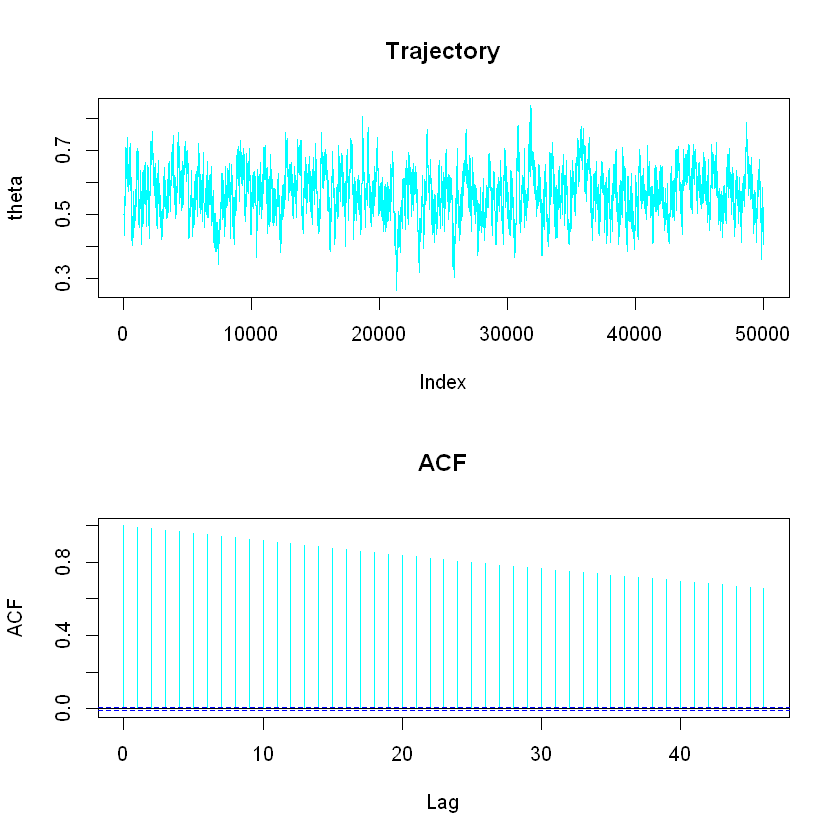

In [68]:
# plot the original trajectory, to assess whether burnIn is adequate
old.par<-par(mfrow=c(2,1))
plot(chain1.raw,type="l",lwd=0.1,col="cyan",ylab="theta",main="Trajectory")
acf(chain1.raw,col="cyan",lwd=1,main="ACF") #~ auto correlation function
par(old.par)

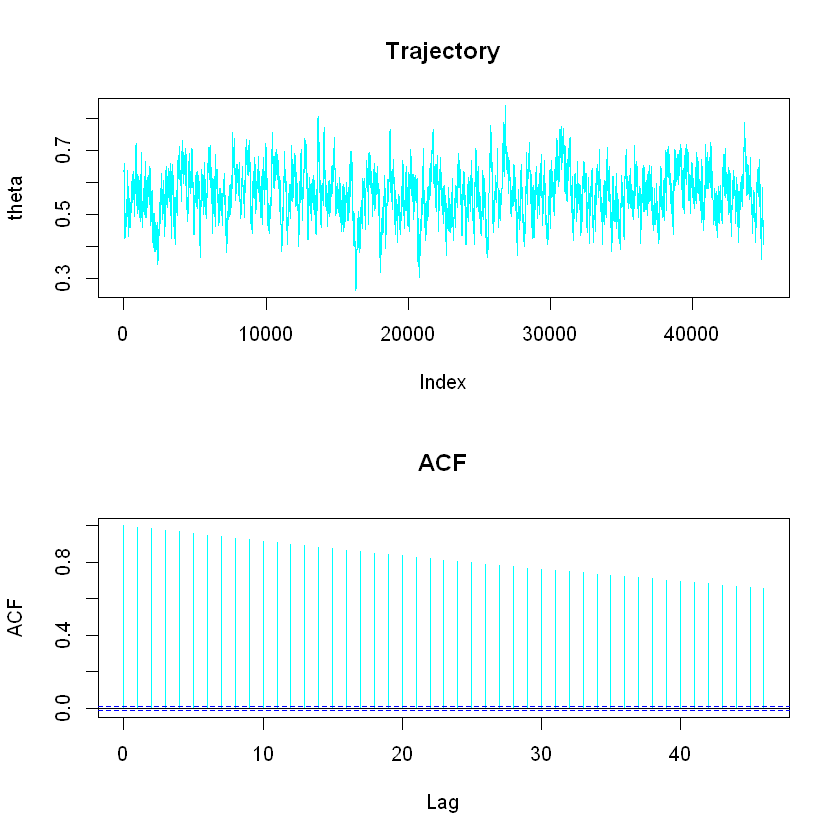

In [69]:
old.par<-par(mfrow=c(2,1))
plot(chain1,type="l",col="cyan",lwd=0.1,ylab="theta",main="Trajectory")
acf(chain1,col="cyan",lwd=1,main="ACF")
par(old.par)

#### Plot histogram with superimposed kernel density estimation

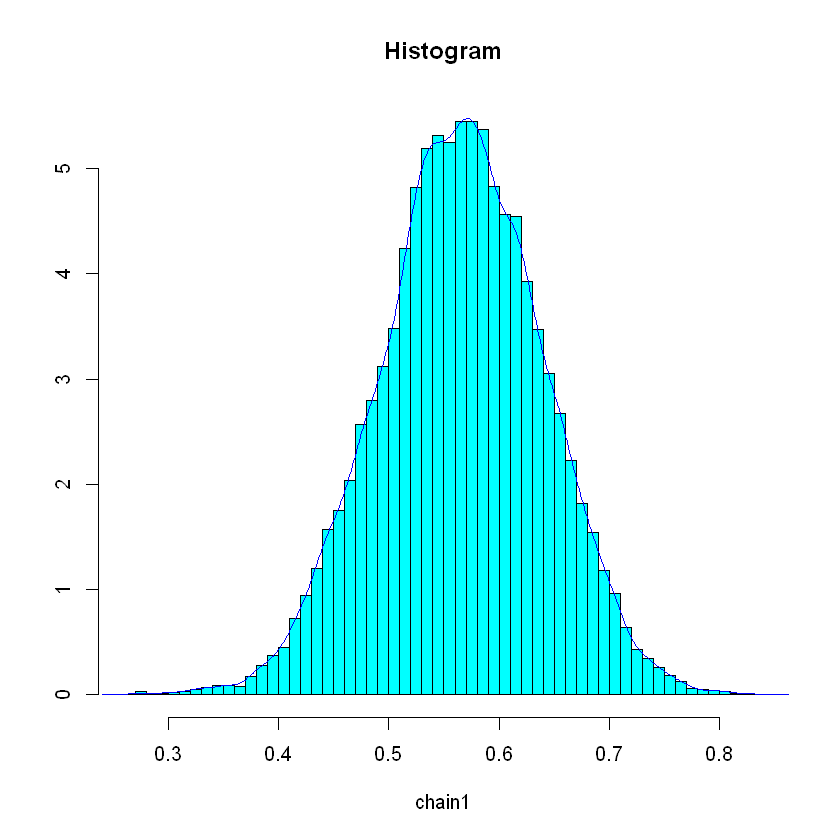

In [70]:
require(MASS)
truehist(chain1,main="Histogram")
lines(density(chain1),lwd=1.5,col="blue")

#### Acceptance rate

A duplicated entry in the chain results from a rejected candidate.

For an overall measure of eficiency we should add both duplications and lost chain steps due to burn-in segment length.

In [71]:
acceptance.rate<-1-mean(duplicated(chain1)) # duplicated: counts the number of duplicated entries in a sequence
round(acceptance.rate,2)
overall.performance<-1-(burnIn+sum(duplicated(chain1)))/Chain.Length
round(overall.performance,2)

[1] 0.96

[1] 0.86

### Experiment

Repeat the above computations, changing:

(1) Dispersion of the candidate generation pdf
(2) The candidate generation pdf itself 

Try to find a good choice of a candidate generation pdf (and its dispersion parameter).

In [72]:
#
#
#

#### Compare chain average, variance, mode with the theoretical posterior quantities

We known the posterior pdf is a beta distribution $Beta(a_1,b_1)$, with parameters:

In [73]:
a1<-a+x
b1<-b+n-x
round(a1,3)
round(b1,3)
#
post.mu<-Beta.mu(a1,b1)
round(post.mu,3)
post.var<-Beta.var(a1,b1)
round(post.var,3)
post.mode<-Beta.mode(a1,b1)
round(post.mode,3)
#
round(mean(chain1),3)
round(var(chain1),3)
h1<-hist(chain1,plot=FALSE)
chain1.mode<-h1$mids[which.max(h1$counts)]
round(chain1.mode,3)

[1] 24.2

[1] 18.8

[1] 0.563

[1] 0.006

[1] 0.566

[1] 0.565

[1] 0.005

[1] 0.575